# Denoising Convolutional Autoencoder, MNIST

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.utils import save_image

## Set Configs

In [3]:
# number of epochs
num_epochs = 10

# images per batch
batch_size = 16

# learning rate for optimizer of autoencoder model
learning_rate = 0.0005

# number of GPUs availabele
n_gpu = 1

## Configure Data Loader

In [4]:
transform = transforms.Compose([
                            transforms.ToTensor(),
])

In [5]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform),
                                           batch_size=batch_size, shuffle=False)

In [6]:
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform),
                                           batch_size=4, shuffle=False)

In [7]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Build Convolutional Autoencoder Architecture

<img src='images/autoencoder-architecture.png' width='75%'/>

In [8]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv_layer = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
            
                        nn.Conv2d(32,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
            
                        nn.Conv2d(32,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
            
                        nn.Conv2d(64,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2),
            
                        nn.Conv2d(64,128,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
            
                        nn.Conv2d(128,128,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
            
                        nn.Conv2d(128,256,3,padding=1),
                        nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(batch_size,-1)
        
        return x

In [9]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()

        self.deconv_layer = nn.Sequential(
                                nn.ConvTranspose2d(256,128,3,2,1,1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
            
                                nn.ConvTranspose2d(128,128,3,1,1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
            
                                nn.ConvTranspose2d(128,64,3,1,1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
            
                                nn.ConvTranspose2d(64,64,3,1,1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
            
                                nn.ConvTranspose2d(64,32,3,1,1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
            
                                nn.ConvTranspose2d(32,1,3,2,1,1),
                                nn.ReLU()
        )
        
    def forward(self, x):
        x = x.view(batch_size,256,7,7)
        x = self.deconv_layer(x)
        
        return x

#### Initialize Autoencoder

In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

## Create A Noise

In [11]:
# check output size of autoencoder network
for i, (images, _) in enumerate(train_loader):
    
    image = Variable(images).to(device)
    
    reconstruction = encoder(image)
    results = decoder(reconstruction)
    
    print(results.size())
    break

torch.Size([16, 1, 28, 28])


In [12]:
# create random noise
noise = torch.rand(batch_size,1,28,28)
noise.shape

torch.Size([16, 1, 28, 28])

## Define Loss Function

In [13]:
reconstruction_loss = nn.MSELoss()
if (device.type == 'cuda'): reconstruction_loss.to(device)

## Set Optimizer

In [14]:
all_parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=learning_rate)

## Train The Network

In [15]:
r_loss_to_display = []
prev_time = time.time()
for epoch in range(num_epochs):
    
    r_loss = []
    for i, (images, _) in enumerate(train_loader):
        
        noisy_images = torch.mul(images+0.25, 0.1 * noise)
        noisy_images = Variable(noisy_images).to(device)
        images = Variable(images).to(device)
        
        optimizer.zero_grad()
        
        reconstruction = encoder(noisy_images)
        results = decoder(reconstruction)
        loss = reconstruction_loss(results, images)
        r_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        # determine approximate time left
        batches_done = epoch * len(train_loader) + i
        batches_left = num_epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        
    r_loss_to_display.append(sum(r_loss)/len(r_loss))
    print('epoch [{}/{}], reconstruction loss: {:.4f}, ETA: {}'.format(epoch+1, num_epochs, loss.data.cpu().numpy(), time_left, ))

if not os.path.exists('./weights/'): os.makedirs('./weights/')
torch.save([encoder,decoder],'./weights/dautoencoder_mnist.pth')
print('\nD-Autoencoder Model saved.')

epoch [1/10], reconstruction loss: 0.0072, ETA: 0:06:31.174224
epoch [2/10], reconstruction loss: 0.0053, ETA: 0:05:47.175249
epoch [3/10], reconstruction loss: 0.0040, ETA: 0:05:12.648405
epoch [4/10], reconstruction loss: 0.0028, ETA: 0:04:35.850635
epoch [5/10], reconstruction loss: 0.0022, ETA: 0:03:38.066282
epoch [6/10], reconstruction loss: 0.0019, ETA: 0:02:46.644238
epoch [7/10], reconstruction loss: 0.0017, ETA: 0:02:17.781230
epoch [8/10], reconstruction loss: 0.0015, ETA: 0:01:24.803085
epoch [9/10], reconstruction loss: 0.0014, ETA: 0:00:46.619386
epoch [10/10], reconstruction loss: 0.0013, ETA: 0:00:00.011121

D-Autoencoder Model saved.


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Evaluate The Network

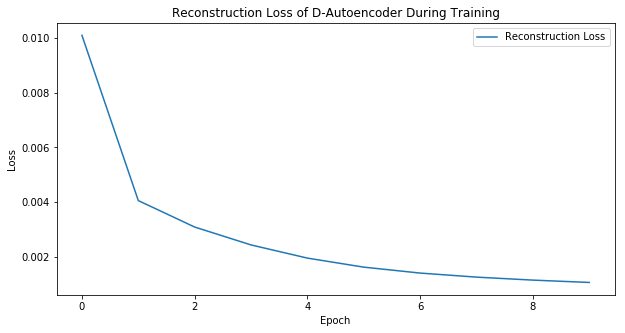

In [16]:
plt.figure(figsize=(10,5))
plt.title("Reconstruction Loss of D-Autoencoder During Training")
plt.plot(r_loss_to_display, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/dautoencoder'): os.makedirs('./images/dautoencoder')
plt.savefig('./images/dautoencoder/final_loss.png')
plt.show()

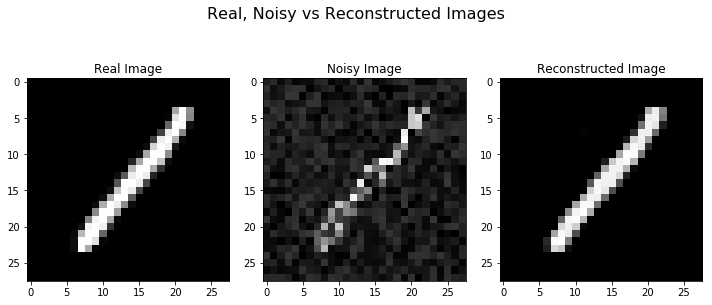

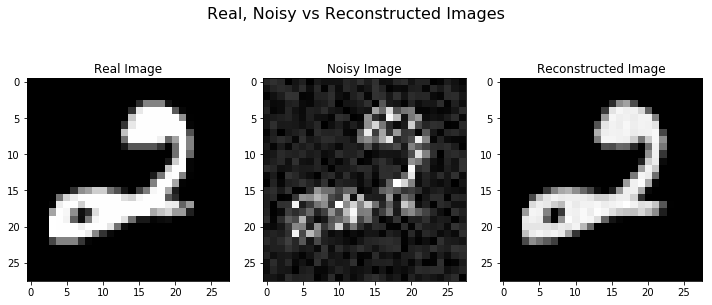

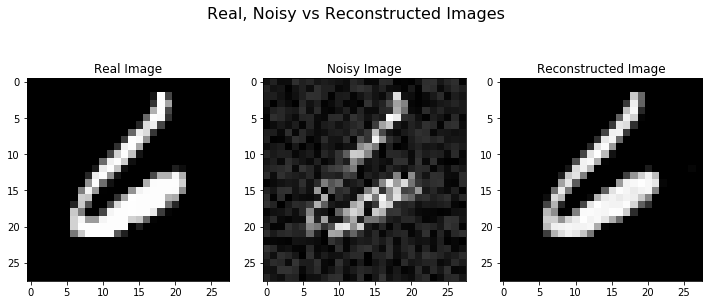

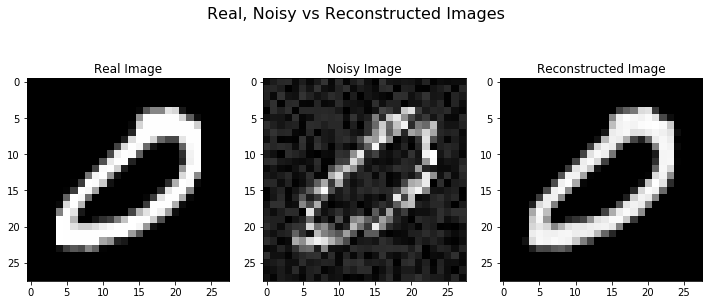

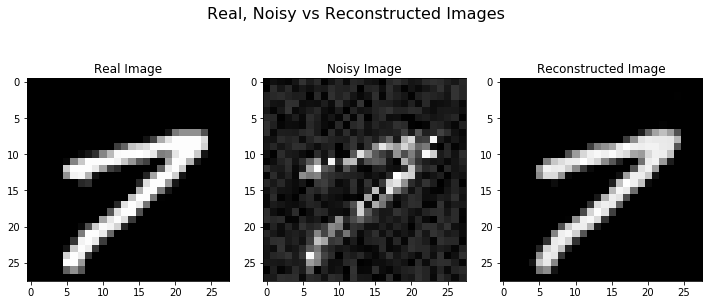

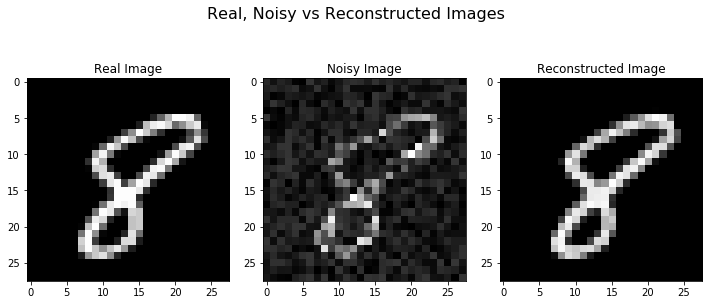

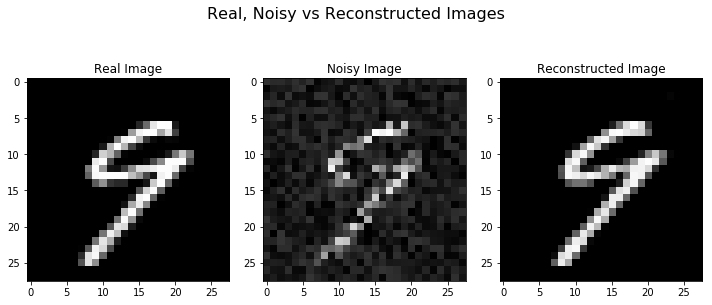

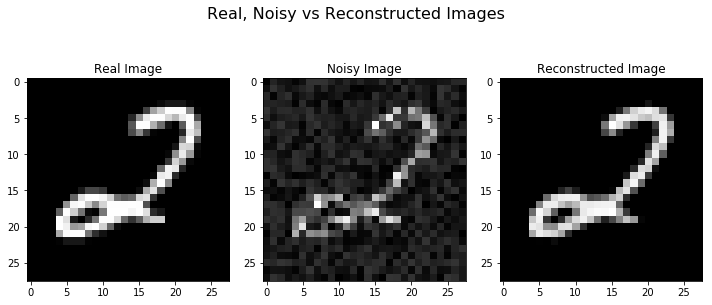

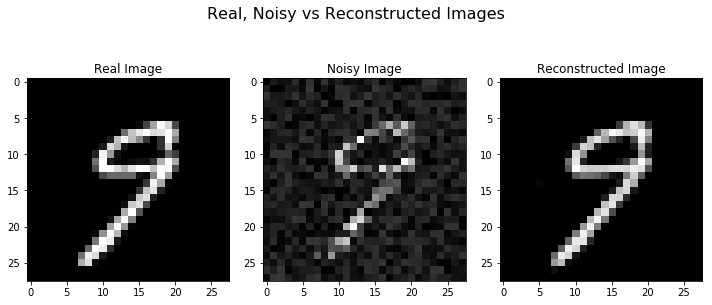

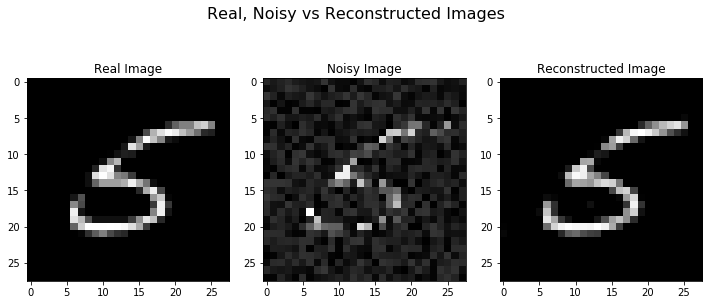

In [17]:
for i in range(10):

    image = images[i].cpu()
    noisy_image = noisy_images[i].cpu()
    result = results[i].cpu()

    fig, axarr = plt.subplots(1,3)
    fig.suptitle("Real, Noisy vs Reconstructed Images", fontsize=16)
    fig.set_size_inches(10, 5, forward=True)

    axarr[0].set_title('Real Image')
    axarr[0].imshow(image[0], cmap='gray')

    axarr[1].set_title('Noisy Image')
    axarr[1].imshow(noisy_image[0], cmap='gray')

    axarr[2].set_title('Reconstructed Image')
    axarr[2].imshow(result.cpu().detach().numpy()[0], cmap='gray')

    fig.tight_layout()
    plt.figure(figsize=(10, 10))
    plt.savefig('./images/dautoencoder/real_noisy_vs_recons{}.png'.format(i+1))

    plt.show()

---